In [1]:
pip install pymc==5.20.0 pytensor==2.26.4 numpy==1.26.4 pandas==2.2.3 matplotlib==3.10.0 scipy==1.15.1 scikit-learn==1.6.1 arviz==0.20.0 jax==0.5.0 jaxlib==0.5.0 seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az
import pytensor.tensor as pt
from sklearn.metrics import accuracy_score


import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
jax.random.PRNGKey(RANDOM_SEED)


def generate_synthetic_data(n_samples=500, n_choices=3, n_features=4, outlier_fraction=0.05):
    """
    Generate synthetic multinomial choice data with some outliers.
    
    - Latent utilities are (X @ beta_true) + noise
    - Outliers are forced to pick the 'wrong' choice
    """
    beta_true = jnp.array([-0.5, 0.75, 0.75, 0.25]) 
    Sigma_true = jnp.array([[1.0, 0.3],
                            [0.3, 1.0]])           

    X = jax.random.uniform(jax.random.PRNGKey(0), (n_samples, n_features), minval=0, maxval=2)

    key = jax.random.PRNGKey(1)
    noise = jax.random.multivariate_normal(key, jnp.zeros(n_choices - 1), Sigma_true, (n_samples,))

    u_utilities = (X @ beta_true).reshape(-1, 1) + noise
    u = jnp.concatenate([u_utilities, jnp.zeros((n_samples, 1))], axis=1)
    y = jnp.argmax(u, axis=1)

    n_outliers = int(n_samples * outlier_fraction)
    outlier_idx = jax.random.choice(key, n_samples, (n_outliers,), replace=False)
    y = y.at[outlier_idx].set(jnp.argmin(u[outlier_idx], axis=1))

    return np.array(X), np.array(y), np.array(beta_true), np.array(Sigma_true)

X, y, beta_true, Sigma_true = generate_synthetic_data()


def robust_multinomial_model(X, y, n_choices=3):
    """
    A *diagonal* Student-T version for each (n_choices-1) dimension.
    
    NOTE: This does NOT incorporate correlation among categories 
    (the real paper's method is a multivariate T). 
    
    Key differences from your original "robust" code:
      - We use StudentT rather than MvNormal.
      - We introduce `nu` (degrees of freedom) for heavy tails.
      - Covariance is diagonal: each dimension gets its own scale.
    """
    n_samples, n_features = X.shape
    
    with pm.Model() as model:
        beta = pm.Normal("beta", mu=0, sigma=5, shape=n_features)
        
        nu = pm.Exponential("nu", 1.0)
        
        sigma = pm.HalfNormal("sigma", sigma=1.0, shape=(n_choices - 1,))
        
        mu_lin = pm.Deterministic("mu_lin", pm.math.dot(X, beta)) 
        mu_rep = pm.math.stack([mu_lin]* (n_choices - 1), axis=1)  
        
        u = pm.StudentT(
            "u",
            nu=nu,
            mu=mu_rep,  
            sigma=sigma,  
            shape=(n_samples, n_choices - 1)
        )
        
        utilities = pt.concatenate([u, pt.zeros((n_samples, 1))], axis=1)
        
        p = pm.Deterministic("p", pm.math.softmax(utilities, axis=1))
        
        pm.Categorical("obs", p=p, observed=y)
        
    return model


def standard_probit_model(X, y, n_choices=3):
    """
    A standard multinomial probit:
      - Latent utilities ~ MvNormal(mean = X*beta, cov = Cholesky(Sigma))
      - We add the baseline category of 0 for the nth choice
      - Then convert to probabilities via softmax
    """
    n_samples, n_features = X.shape
    
    with pm.Model() as model:
        beta = pm.Normal("beta", mu=0, sigma=5, shape=n_features)

        chol, corr, stds = pm.LKJCholeskyCov(
            "chol",
            n=n_choices - 1,
            eta=2,
            sd_dist=pm.HalfNormal.dist(1.0),
            compute_corr=True
        )

        mu_lin = pm.math.dot(X, beta)[:, None]  
        
        u = pm.MvNormal(
            "u",
            mu=mu_lin,     
            chol=chol, 
            shape=(n_samples, n_choices - 1)
        )

        utilities = pt.concatenate([u, pt.zeros((n_samples, 1))], axis=1)

        p = pm.Deterministic("p", pm.math.softmax(utilities, axis=1))

        pm.Categorical("obs", p=p, observed=y)

    return model



print("Sampling Robust (Student-T) Model...")
with robust_multinomial_model(X, y) as model_robust:
    trace_robust = pm.sample(
        draws=2000,
        tune=1000,
        chains=2,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True}
    )


Sampling Robust (Student-T) Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, nu, sigma, u]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 170 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling Standard Probit Model...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, chol, u]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 149 seconds.
There were 368 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


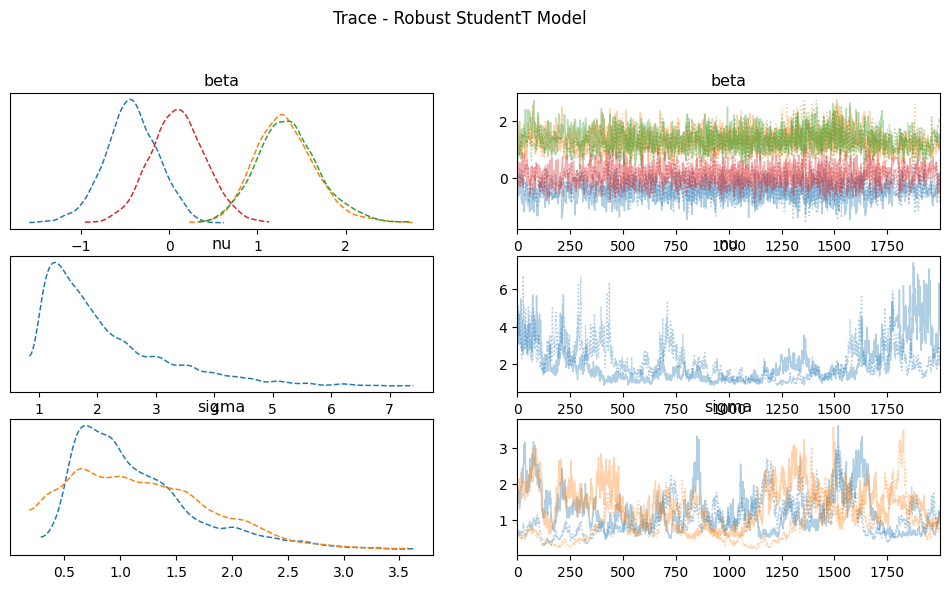

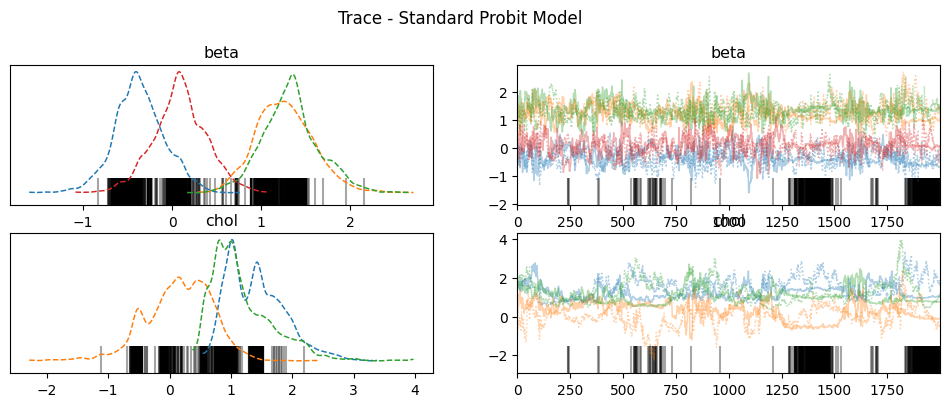

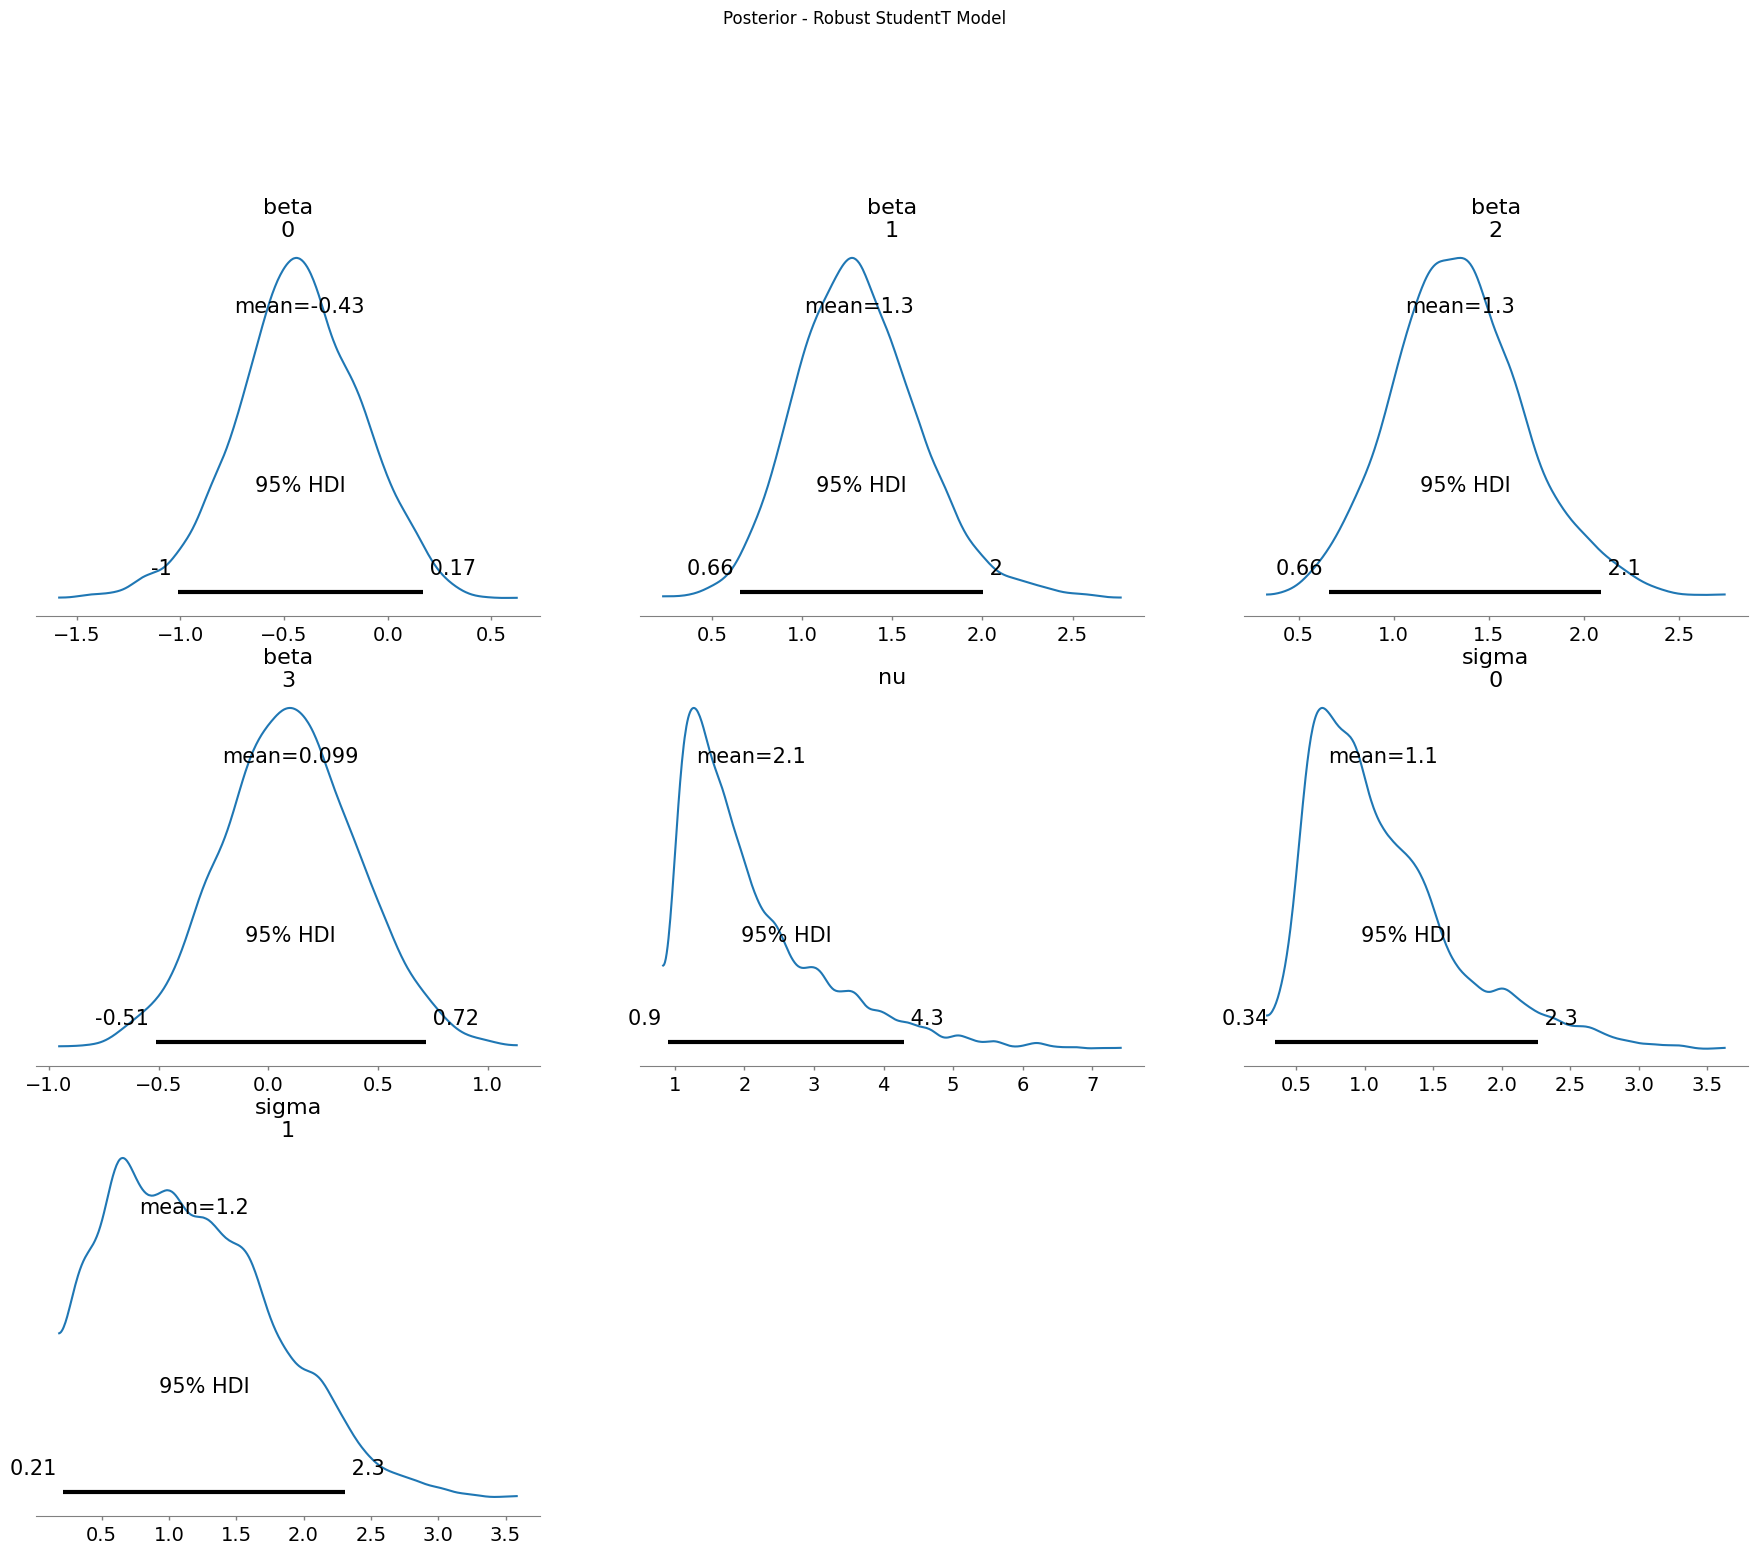

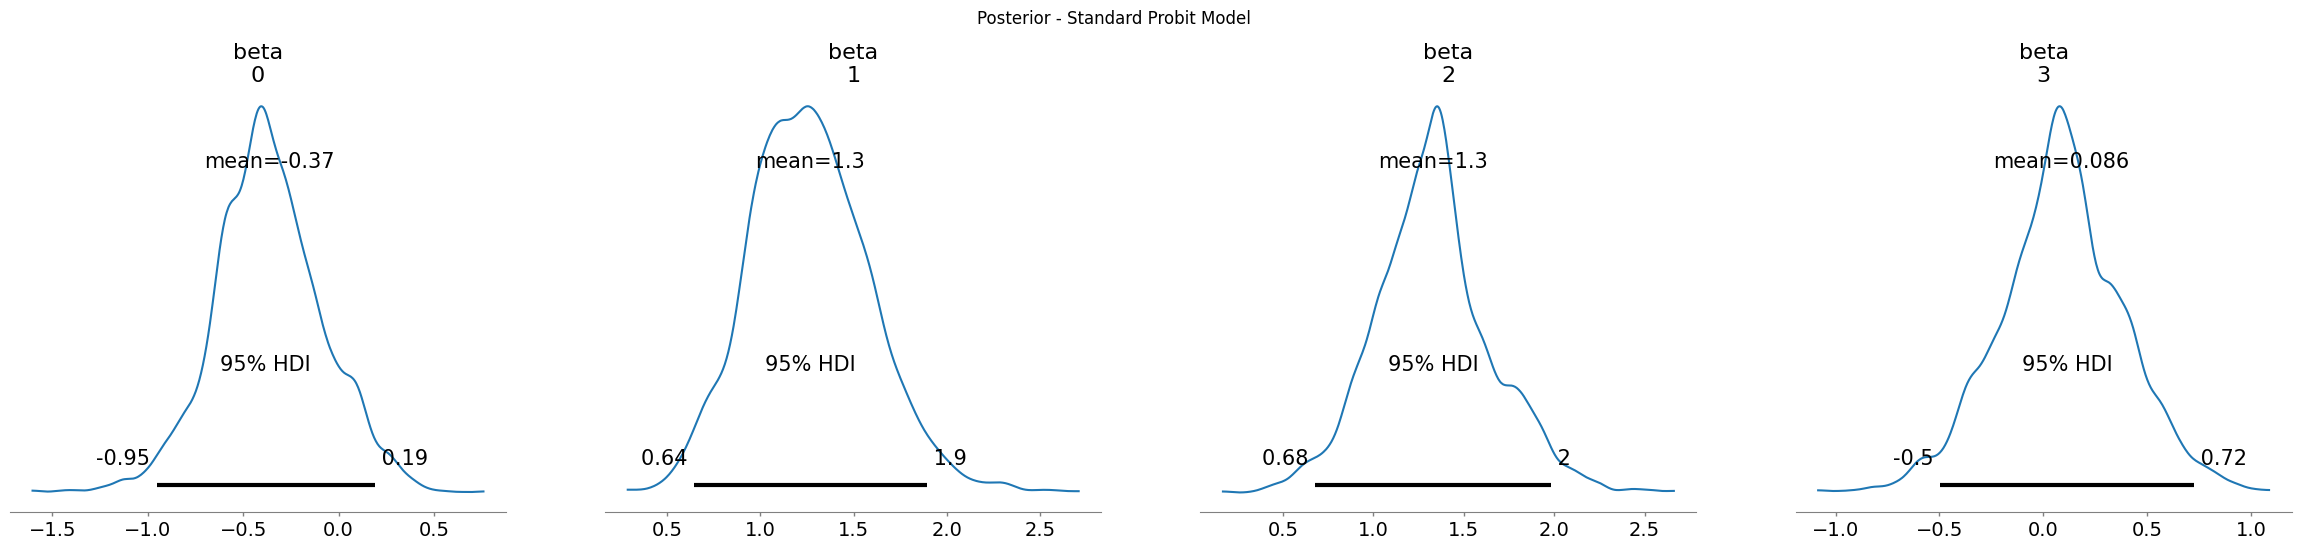

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


         rank    elpd_loo       p_loo  elpd_diff  weight         se       dse  \
RobustT     0  838.049007  194.859252   0.000000     1.0  21.904059  0.000000   
Probit      1  889.923929  164.802332  51.874922     0.0  22.121993  2.764819   

         warning     scale  
RobustT     True  deviance  
Probit      True  deviance  


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


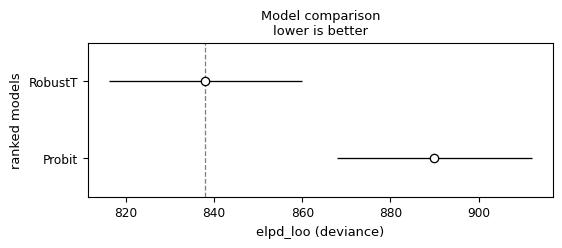

In [3]:

print("Sampling Standard Probit Model...")
with standard_probit_model(X, y) as model_probit:
    trace_probit = pm.sample(
        draws=2000,
        tune=1000,
        chains=2,
        cores=1,   
        target_accept=0.9,
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True}
    )



az.plot_trace(trace_robust, var_names=["beta", "nu", "sigma"], combined=True)
plt.suptitle("Trace - Robust StudentT Model", y=1.02)
plt.show()

az.plot_trace(trace_probit, var_names=["beta", "chol"], combined=True)
plt.suptitle("Trace - Standard Probit Model", y=1.02)
plt.show()


az.plot_posterior(trace_robust, var_names=["beta", "nu", "sigma"], hdi_prob=0.95)
plt.suptitle("Posterior - Robust StudentT Model", y=1.02)
plt.show()

az.plot_posterior(trace_probit, var_names=["beta"], hdi_prob=0.95)
plt.suptitle("Posterior - Standard Probit Model", y=1.02)
plt.show()

model_compare = az.compare(
    {"RobustT": trace_robust, "Probit": trace_probit},
    ic="loo",
    scale="deviance"
)
print(model_compare)
az.plot_compare(model_compare)
plt.show()



Sampling: [obs]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/mehdielkacemy/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


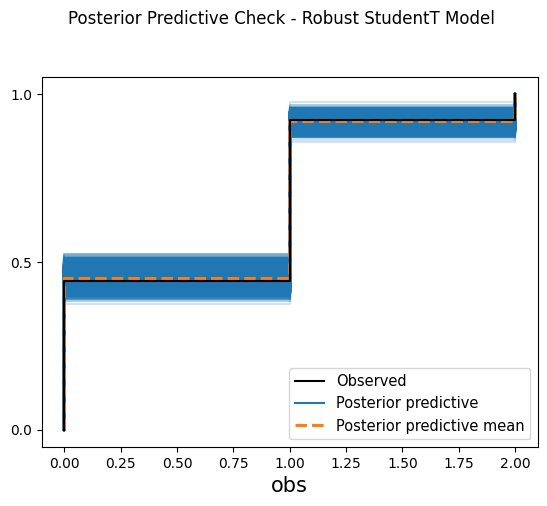

In [4]:

with robust_multinomial_model(X, y):
    ppc_robust = pm.sample_posterior_predictive(
        trace_robust,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED
    )

az.plot_ppc(
    data=ppc_robust,
    group="posterior",  
    kind="cumulative"
)
plt.suptitle("Posterior Predictive Check - Robust StudentT Model", y=1.02)
plt.show()